# Fang & Oosterle (2008) : A novel pricing method for european options based on Fourier-Cosine series expansions (Part I/II) and Heston (1993)

The goal of the Heston Model is the pricing of options based on the Heston stochastic volatility model (Heston, 1993). To solve the Heston Model, we use Fang and Osterle's (2008) COS-FFT transformation. With the COS-FFT, we are able to calculate the p.d.f. of a characteristic function on a general interval. The density of the probabilistic function of the Heston model is  used to calculate option prices.

Formulas and text are from [Fang & Oosterle 2008](https://search.proquest.com/docview/921045379?pq-origsite=gscholar) paper. Chapter and equation numbers also correspond)

In [1]:
%matplotlib inline

import time
import cmath   # c stands for complex (to handle complex numbers)
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma as gamma_fn

import warnings
warnings.simplefilter('ignore')

## 3. Pricing European Options

### 3.1. Coeﬃcients $V_k$ for Plain Vanilla Options
Before we can use (19) for pricing options, the payoﬀ series coeﬃcients, $V_k$ , have to be recovered. We can ﬁnd analytic solutions for $V_k$ for several contracts (Fang & Ooesterle, 2008)

Both the cosine series coeﬃcients, $\chi_k$  and $\psi_k$ are known analytically.

<img style="float: left;" src="figures/f_22_23.png" width="580">


In [2]:
# equation (22)
def chi_cosine_series_coeff(k, a, b, c, d):
    """
    Helper Function (22) in the F&O paper
    Args:
        k : coeﬃcients of the summand (runs from 0 to N-1)
        a : float, left border of the trucated integral
        b : float, right border of the truncated integral 
        c : 0
        d : a or b
    Returns:
        chi_k : ndarray with N floats, a cosine series coefficient ndarray
    """
    multiplier = 1 / (1 + (k* np.pi / (a - b))**2 )
    
    cos1 = np.cos( k * np.pi * ( (d-a)/(b-a) ) ) * np.exp(d)
    cos2 = np.cos( k * np.pi * ( (c-a)/(b-a) ) ) * np.exp(c)
    
    sin1 = (k * np.pi)/(b-a) * np.sin( k * np.pi * ( (d-a)/(b-a) ) ) * np.exp(d)
    sin2 = (k * np.pi)/(b-a) * np.sin( k * np.pi * ( (c-a)/(b-a) ) ) * np.exp(c)
    
    in_brakets = cos1 - cos2 + sin1 - sin2

    return multiplier * in_brakets
    
# equation (23)
def psi_cosine_series_coeff(k, a, b, c, d):
    """
    Helper Function (23) in the F&O paper
    Args:
        k : int, coeﬃcients of the summand (runs from 0 to N-1)
        a : float, left border of the trucated integral
        b : float, right border of the truncated integral
        c : 0
        d : a oder b
        
    Returns:
        psi_k : ndarray with N floats, a cosine series coefficient ndarray
    """
    pi = np.pi
    
    sin1 = np.sin(k * pi * (d-a)/(b-a))
    sin2 = np.sin(k * pi * (c-a)/(b-a))
    in_brakets = sin1 - sin2
        
    y = in_brakets * (b-a) / (k * pi)
    y[0] = (d-c)
    
    return y
        

### 3.3. Formula for Lévy Processes and the Heston Model

<img style="float: left;" src="figures/Uk.png" width="680">

In [3]:
def UK(k, a, b, style):
    """
    Helper function for COS_FFT, (Fang & Osterle (2008), p. 6-7. )
    Equation (29) in F&O paper. Calculates Uk.
    Uses formula (22) and (23)
    In:
        k : int, coeﬃcients of the summand (runs from 0 to N-1)
        a : float, left border of the trucated integral
        b : float, right border of the truncated integral
        style: bool, indicating whether the option is a call
    Returns:
        U:        ndarray of N floats, function value of UK
    """    
    # if the option is a call
    if style == 'call':
        chi_k = chi_cosine_series_coeff(k, a, b, 0, b) 
        psi_k = psi_cosine_series_coeff(k, a, b, 0, b)

        return (2 / (b - a)) * (chi_k - psi_k)
        
    # if the option is a put
    elif style == 'put':
        chi_k = chi_cosine_series_coeff(k, a, b, a, 0) 
        psi_k = psi_cosine_series_coeff(k, a, b, a, 0)
        
        return (2 / (b - a)) * (-chi_k + psi_k)

### Lévy

For the CGMY/KoBol model, which encompasses the __Geometric Brownian Motion (GBM)__ and __Variance Gamma (VG)__ models, the characteristic function of the log-asset price is of the form:

<img style="float: left;" src="figures/f_31.png" width="680">
<img style="float: left;" src="figures/f_56.png" width="480">

In [4]:
class LevyCharFunction:
    def __init__(self, model):
        """
        Initial values according to (56) in F&O paper
        """
        self.model = model
        
        self.r = 0.1
        self.q = 0.

        # default is CGMY settings
        self.C = 1.
        self.G = 5.
        self.M = 5.
        self.Y = 0.5
        
        self.mu = self.r
        self.sigma = 0.12  # as in eq(51)       
            
        if self.model == 'GBM':
            self.C = 0.    # if C == 0, the values of G,M,Y don't matter
            self.sigma = 0.25  # as in eq(51)

        elif self.model == 'VG':
            # according to (55)
            self.sigma = 0.12
            self.theta = -0.14
            self.nu = 0.2
            
            self.Y = 0.   # as described on page 8 
            
            # C,G and M are defined as in (54)
            self.C = 1 / self.nu
            
            inside_sqrt = self.theta**2/self.sigma**4 + 2/(self.nu*self.sigma**2)

            self.G = self.theta / self.sigma**2 + cmath.sqrt(inside_sqrt)
            self.M = -self.theta/self.sigma**2 + cmath.sqrt(inside_sqrt)
            
    def evaluate(self, omega, tau):
        """
        Defined in eq(31) F&O paper
        """

        exp1 = np.exp(1j*omega*(self.r-self.q)*tau-0.5*omega**2*self.sigma**2*tau)
        
        if self.Y != 0:
            first = (self.M-1j*omega)**self.Y - self.M**self.Y
            second = (self.G+1j*omega)**self.Y - self.G**self.Y
            in_brackets = first + second
            exp2 = np.exp((tau*self.C*gamma_fn(-self.Y))*in_brackets)
        
            return exp1 * exp2
        
        # because Y=0 causes exp2=1
        else:
            return exp1
        
        
    def get_ab(self, tau):
        """
        Defined in appendix, Table 11
        """
        if self.model == 'GBM':
            c1 = self.mu * tau
            c2 = self.sigma**2 * tau
            c4 = 0
        
        elif self.model == 'VG':
            c1 = (self.mu + self.theta) * tau
            c2 = (self.sigma**2 + self.nu*self.theta**2) * tau
             
            first_summand = self.sigma**4 *self.nu
            second_summand = 2* self.theta**4 *self.nu**3
            third_summand = 4* self.sigma**2 *self.theta**2 *self.nu**2
            in_braces =  first_summand + second_summand + third_summand
            c4 = 3 * in_braces * tau
        
        elif self.model == 'CGMY':
            first_multip = self.C*tau*gamma_fn(1-self.Y)
            second_multip = self.M**(self.Y-1)-self.G**(self.Y-1)
            c1 = self.mu*tau + first_multip * second_multip
        
            first_multip = self.C*tau*gamma_fn(2-self.Y)
            second_multip = self.M**(self.Y-2)-self.G**(self.Y-2)
            c2 = self.sigma**2*tau + first_multip * second_multip
        
            first_multip = self.C*tau*gamma_fn(4-self.Y)
            second_multip = self.M**(self.Y-4)-self.G**(self.Y-4)
            c4 = first_multip * second_multip
            
        # eq(49)
        root = 10*np.sqrt( c2 + np.sqrt(c4) )
        a_param = c1 - root 
        b_param = c1 + root
        
        return a_param, b_param

### Heston
<img style="float: left;" src="figures/heston.png" width="480">

In [5]:
class HestonCharFunction:
    def __init__(self):
        """
        Characteristic function of Heston Model based on Fang & Oosterle (2008), p. 8.

        self.u_0 = variance at t=0
        self.lam = mean reversion
        self.eta = volatility of volatility
        self.mu = drift of Brownian Motion (here interest rate)
        self.rho = correlation coefficient Brownian Motion
        self.uBar = mean level of variance

        """
        # parameters as in (53)
        self.r = 0.
        self.q = 0.

        self.u_0 = 0.0175
        self.lam = 1.5768
        self.eta = 0.5751
        self.mu = self.r
        self.rho = -0.5711 
        self.uBar = 0.0398
    
    def evaluate(self, ome, tau):
        """
        ome = ndarray of length N
        tau = years to maturity

        Returns ndarray of N floats
        """

        first = ( self.lam - 1j * self.rho * ome * self.eta ) ** 2
        second = ( ome ** 2 + ome * 1j ) * self.eta ** 2
        D = (first + second) ** (0.5)

        nom = (self.lam - 1j * self.rho * ome * self.eta - D)
        denom = (self.lam - 1j * self.rho * ome * self.eta + D)
        G = nom / denom

        first_summand = 1j * ome * self.mu * tau

        first_factor = (self.u_0 / self.eta ** 2)
        second_factor = (1 - np.exp(-D * tau)) / (1 - G * np.exp(-D * tau))
        third_factor = self.lam - 1j * self.rho * ome * self.eta - D

        second_summand =  first_factor * second_factor * third_factor 

        exp1 = np.exp(first_summand + second_summand)


        first_factor = ((self.lam * self.uBar)/self.eta ** 2)

        first = tau * (self.lam - 1j * self.rho * ome *self.eta -D)
        second = 2 * np.log((1-G * np.exp(-D * tau))/(1-G))
        second_factor = (first - second)

        exp2 = np.exp( first_factor * second_factor )

        phi_hes = exp1 * exp2

        return phi_hes
    
    def get_ab(self, tau):
        a_param = -5 * np.sqrt(self.uBar + self.uBar * self.eta)
        b_param = 5 * np.sqrt(self.uBar + self.uBar * self.eta) 
        return a_param, b_param

### Pricing

<img style="float: left;" src="figures/pricing.png" width="680">

In [6]:
def pricing(K, S, N, tau, char_fun, style):
    """
    Implements eq (30) of the F&O paper
    """
    
    x = np.log(S/K)   #from page 6
    
    a, b = char_fun.get_ab(tau)
    
    k = np.arange(0,N)       # vector used to sum over k
    ome = k * np.pi / (b-a)  # the expression inside the characteristic fn
    
    r_param = char_fun.r
    q_param = char_fun.q
    
    weights = np.ones(N)
    weights[0] = 0.5 # setting first weight to half

    prices = np.zeros(len(K))
    
    for s in range(0, len(K)):
        
        exponential = np.exp(1j * ome * (x[s] -a))
        
        phi_omega = char_fun.evaluate(ome, tau)
        
        real_part = np.real(sum(weights * phi_omega * UK(k, a, b, style) * exponential))

        prices[s] = (K[s] * np.exp(-r_param * tau) * real_part )
    
    #if below is uncommented, change UK to UK(k, a, b, 'put') instead of style
#    if style == 'call':
#        #use put call parity described in (50)
#        prices = prices + S*np.exp(-q_param*tau) - K*np.exp(-r_param*tau)
    
    return prices 

## 5. Numerical Results

In [7]:
def run_experiment(T, ref_values, specifications):
    """
    """
    K,S,char_fun,style = specifications

    print("T = %s \t Reference val. = %s\n" % (T, ref_values))
    print("N \t max. abs. err. \t time(msec)") 
    for w in range(6,11):
        N = 2**w
        prices = pricing(K, S, N, T, char_fun, style)
        errors = ref_values-prices
        max_abs_error = max(abs(errors))
        
        start = time.time()
        for i in range(100):
            pricing(K, S, N, T, char_fun, style)
        elapsed_time = (time.time() - start)
        
        # average and convert to milliseconds
        elapsed_time = 1000*elapsed_time/100
        
        print("%s \t %s \t %s" % (N, max_abs_error, elapsed_time))
    print("\n\n")
    

## 5.2. Geometric Brownian Motion, GBM.

### Table 2

In [8]:
K = np.array([80, 100, 120])   # strike prices
S = 100              # initial price

T = 0.1
reference_values = np.array([20.799226309, 3.659968453, 0.044577814])

specifications = (K,S,LevyCharFunction('GBM'),'call')

run_experiment(T, reference_values, specifications)

T = 0.1 	 Reference val. = [ 20.79922631   3.65996845   0.04457781]

N 	 max. abs. err. 	 time(msec)
64 	 0.312577476126 	 0.5675125122070312
128 	 0.312577476126 	 0.8471775054931641
256 	 0.312577476126 	 0.8473801612854004
512 	 0.312577476126 	 1.071162223815918
1024 	 0.312577476126 	 1.6080403327941895





## 5.3. The Heston Model

In [9]:
K = np.array([100])  # strike price
S = 100 
specifications = (K,S,HestonCharFunction(),'call')

In [10]:
T = 1   # years to maturity
reference_value = 5.785155450 

run_experiment(T,reference_value,specifications)

T = 1 	 Reference val. = 5.78515545

N 	 max. abs. err. 	 time(msec)
64 	 4.04972937194e-05 	 0.34868955612182617
128 	 3.63736341571e-05 	 0.3204822540283203
256 	 3.63735351652e-05 	 0.4428291320800781
512 	 3.63735351652e-05 	 0.5388402938842773
1024 	 3.63735351652e-05 	 0.9010601043701172





In [11]:
T = 10   # years to maturity
reference_value=22.318945791

run_experiment(T,reference_value,specifications)

T = 10 	 Reference val. = 22.318945791

N 	 max. abs. err. 	 time(msec)
64 	 0.295672959141 	 0.31295061111450195
128 	 0.295672959141 	 0.4453587532043457
256 	 0.295672959141 	 0.37607908248901367
512 	 0.295672959141 	 0.5328702926635742
1024 	 0.295672959141 	 0.934138298034668





Repeat the experiment for `T=1` but now with 21 consecutive strikes, `K = [50, 55, 60, · · · , 150]`

cpu time (msec.):  17.670000000000297 



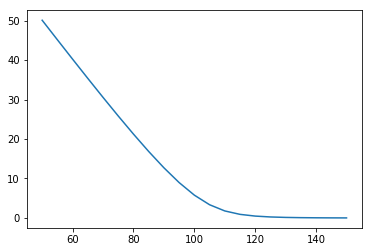

In [12]:
T=1
N=160
K = np.array([j for j in range(50,151,5)])
t = time.process_time()
prices = pricing(K, S, N, T, HestonCharFunction(), 'call')
elapsed = time.process_time()-t
print("cpu time (msec.): ", 1000*elapsed, "\n")
plt.plot(K, prices);

## 5.4. Variance Gamma, VG.

In [13]:
K = np.array([90]) # strike price, ndarray
S = 100              # initial price
specifications = (K,S,LevyCharFunction('VG'),'call')

### Table 7

In [14]:
T = .1
reference_value = 10.993703187

run_experiment(T, reference_value,specifications)

T = 1
reference_value = 19.099354724
run_experiment(T, reference_value,specifications)

T = 0.1 	 Reference val. = 10.993703187

N 	 max. abs. err. 	 time(msec)
64 	 0.0250527300358 	 0.25774717330932617
128 	 0.0250523647831 	 0.2005624771118164
256 	 0.0250523647831 	 0.3206014633178711
512 	 0.0250523647831 	 0.31856298446655273
1024 	 0.0250523647831 	 0.4838395118713379



T = 1 	 Reference val. = 19.099354724

N 	 max. abs. err. 	 time(msec)
64 	 0.354346633342 	 0.24876832962036133
128 	 0.354346633429 	 0.2763223648071289
256 	 0.354346633429 	 0.31697988510131836
512 	 0.354346633429 	 0.3419303894042969
1024 	 0.354346633429 	 0.47234058380126953





## 5.5. CGMY

### Table 8

In [15]:
K = np.array([100]) # strike price, ndarray
S = 100              # initial price

char_fun = LevyCharFunction('CGMY')
char_fun.Y = 0.5

specifications = (K,S,char_fun,'call')

T = 1
reference_value = 19.812948843

run_experiment(T, reference_value,specifications)

T = 1 	 Reference val. = 19.812948843

N 	 max. abs. err. 	 time(msec)
64 	 6.584254186 	 0.3044462203979492
128 	 6.584254186 	 0.32855987548828125
256 	 6.584254186 	 0.35023927688598633
512 	 6.584254186 	 0.4033493995666504
1024 	 6.584254186 	 0.5602908134460449





### Table 9

In [16]:
K = np.array([100]) # strike price, ndarray
S = 100              # initial price

char_fun = LevyCharFunction('CGMY')

# we can easily specify a different Y value for the CGMY model by
char_fun.Y = 1.5

reference_value = 49.790905469 
T = 1

specifications = (K,S,char_fun,'call')

run_experiment(T, reference_value,specifications)

T = 1 	 Reference val. = 49.790905469

N 	 max. abs. err. 	 time(msec)
64 	 1.62755940068 	 0.34442901611328125
128 	 1.62755940068 	 0.35337209701538086
256 	 1.62755940068 	 0.3416895866394043
512 	 1.62755940068 	 0.48425912857055664
1024 	 1.62755940068 	 0.7522988319396973



